# CA5 - Phase 2 - **Convolutional Neural Network**
### Fatemeh Shahhosseini / 810199440

 

# Goal
Implementation of a convolutional neural network using `tensorflow` library and investigating the effect of different optimizers, training data imbalance and regularization methods on model accuracy.

# Total description
1. In the first part, after loading the `CIFAR-10` dataset and preprocessing the test and train data, we build a CNN model using differnet layers then compile it with two optimizers, `RMS` and `Adam`, to classify the data into 10 classes.
2. In the second part, we remove 80% sample of two classes and try to train model with imbalanced data.
3. In the third part, we used data augmentation to balance the data and compare the accuracy with first part.
4. In the last part, we evaluate the effect of regulatization methods like `dropout` and `batch normalizing` in accuracy and recall of CNN model.

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import itertools
from sklearn.metrics import classification_report
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers


print(tf.__version__)

2.12.0


# 0. Pre-process
## Load Data 

In [3]:
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = y_train.flatten()
y_test = y_test.flatten()
classes = ['airp', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

170498071/170498071 [==============================] - 2s 0us/step


# Distribution of data
The primary data are perfectly balanced. As you can see each category has 5000 images in the train data and 1000 images in the test data.

[[Text(0, 0, 'airp'),
  Text(1, 0, 'car'),
  Text(2, 0, 'bird'),
  Text(3, 0, 'cat'),
  Text(4, 0, 'deer'),
  Text(5, 0, 'dog'),
  Text(6, 0, 'frog'),
  Text(7, 0, 'horse'),
  Text(8, 0, 'ship'),
  Text(9, 0, 'truck')]]

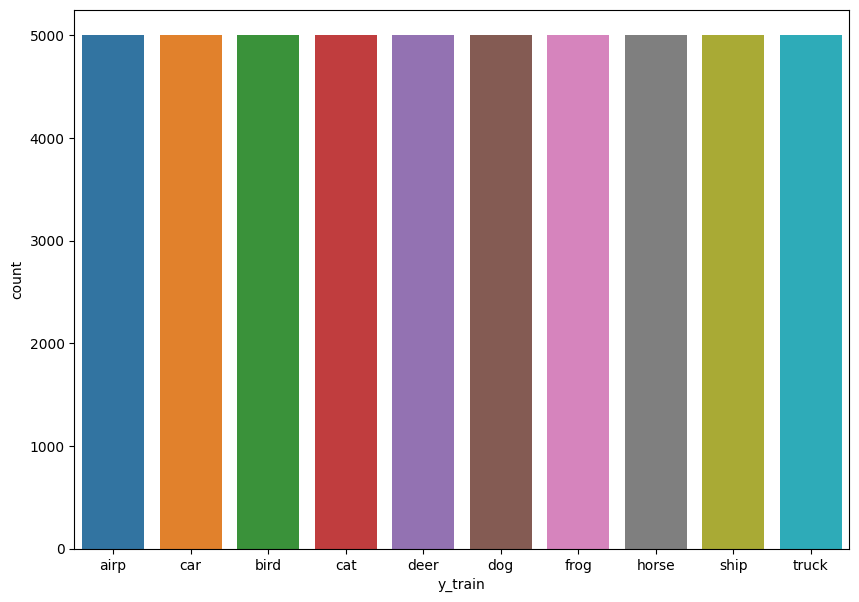

In [4]:
plt.figure(figsize=(10,7))
df = pd.DataFrame({'y_train':y_train})
p = sns.countplot(df, x = 'y_train')

p.set(xticklabels=classes)

[[Text(0, 0, 'airp'),
  Text(1, 0, 'car'),
  Text(2, 0, 'bird'),
  Text(3, 0, 'cat'),
  Text(4, 0, 'deer'),
  Text(5, 0, 'dog'),
  Text(6, 0, 'frog'),
  Text(7, 0, 'horse'),
  Text(8, 0, 'ship'),
  Text(9, 0, 'truck')]]

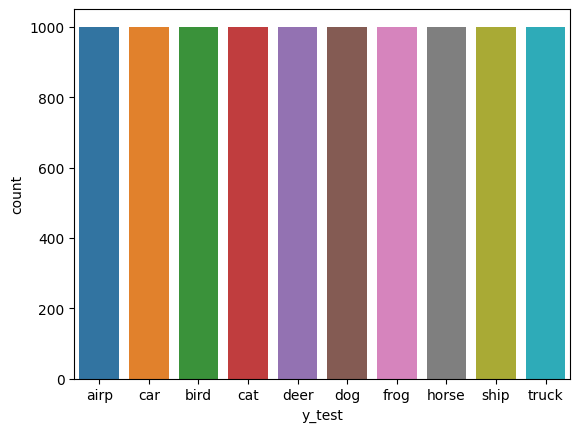

In [5]:
df = pd.DataFrame({'y_test':y_test})
p = sns.countplot(df, x = 'y_test')

p.set(xticklabels=classes)

## Check for NaN Values
There are no NaN values in our dataset. There is no need to preprocess the data to deal with NaN's.

In [6]:
print(np.isnan(x_train).any(), 
      np.isnan(x_test).any()
)

False False


## Normalization and Reshaping
We want each pixel value to be between 0.0 and 1.0. As all values originally fall under the 0-255 range, divide by 255.

In [7]:
input_shape = (32, 32, 3)

x_train=x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 3)
x_train=x_train / 255.0
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 3)
x_test=x_test / 255.0

## Visualize Data
Now it is time to see an image from each category.

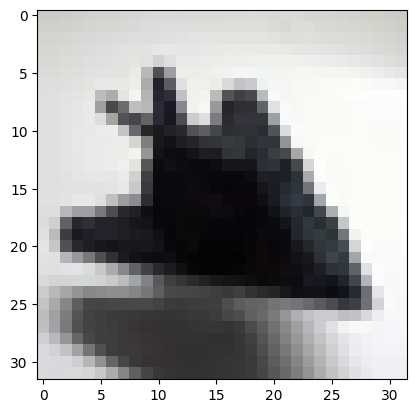

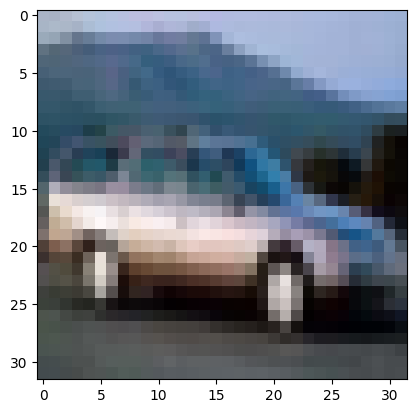

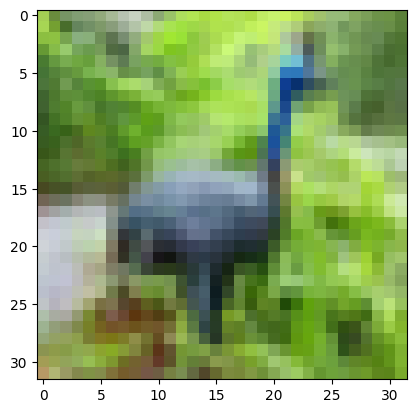

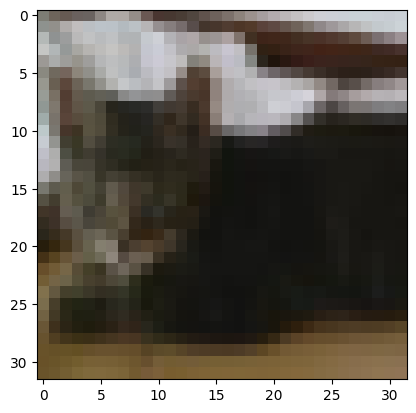

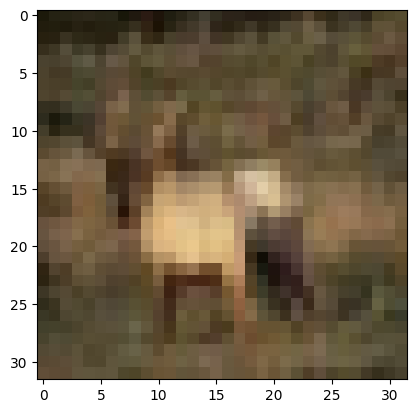

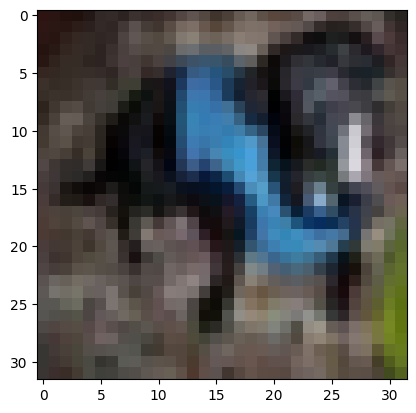

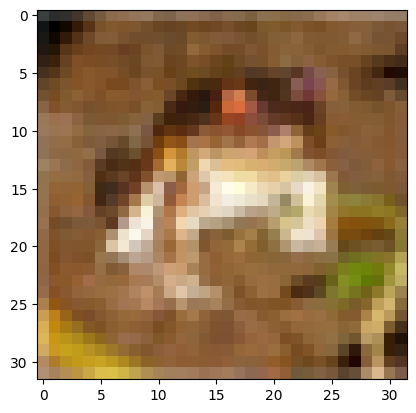

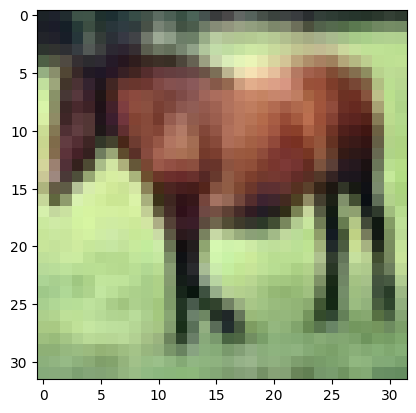

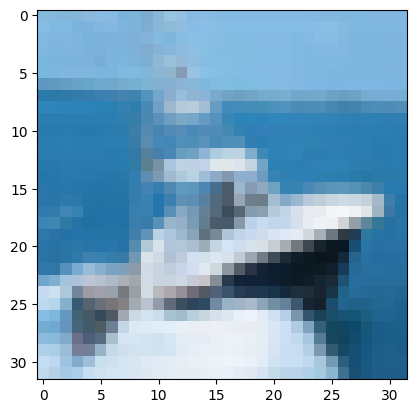

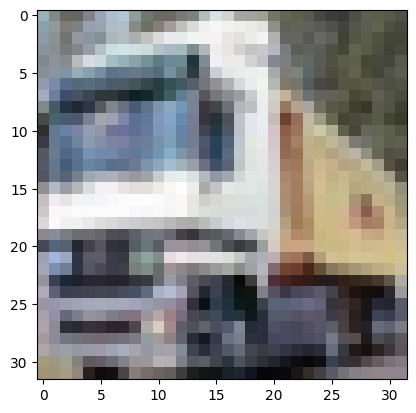

In [8]:
ds = pd.DataFrame()
for i in range (10):
  ds[classes[i]] = np.where(y_train == i)[0]
  pic_index = ds[classes[i]][0]
  fig, ax =  plt.subplots()
  ax.imshow(x_train[pic_index])
  plt.show()

In [9]:
ds

,airp,car,bird,cat,deer,dog,frog,horse,ship,truck
0,29,4,6,9,3,27,0,7,8,1
1,30,5,13,17,10,40,19,11,62,2
2,35,32,18,21,20,51,22,12,69,14
3,49,44,24,26,28,56,23,37,92,15
4,77,45,41,33,34,70,25,43,100,16
...,...,...,...,...,...,...,...,...,...,...
4995,49921,49977,49969,49970,49954,49938,49949,49943,49960,49931
4996,49930,49989,49972,49975,49974,49957,49952,49961,49967,49945
4997,49941,49993,49987,49979,49981,49964,49962,49965,49968,49963
4998,49992,49998,49991,49982,49984,49980,49966,49978,49976,49971


## Label Encoding (One Hot)

In [10]:
y_train_onehot = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test_onehot = tf.one_hot(y_test.astype(np.int32), depth=10)

# 1.Build CNN
## Define the Model

In [11]:
num_classes = 10

In [12]:
def create_model(x_train, dropout_en = 0, batch_norm_en = 0, num_classes = num_classes):
    cnn = tf.keras.models.Sequential()
    cnn.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
    cnn.add(tf.keras.layers.Activation('relu'))
    cnn.add(tf.keras.layers.Conv2D(32, (3, 3)))

    if(batch_norm_en):
      cnn.add(tf.keras.layers.BatchNormalization(synchronized=True))

    cnn.add(tf.keras.layers.Activation('relu'))
    cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same'))

    if(batch_norm_en):
      cnn.add(tf.keras.layers.BatchNormalization(synchronized=True))
      
    cnn.add(tf.keras.layers.Activation('relu'))
    cnn.add(tf.keras.layers.Conv2D(64, (3, 3)))
    cnn.add(tf.keras.layers.Activation('relu'))
    cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn.add(tf.keras.layers.Flatten())
    cnn.add(tf.keras.layers.Dense(512))

    if(dropout_en):
      cnn.add(tf.keras.layers.Dropout(0.25))

    cnn.add(tf.keras.layers.Activation('relu'))
    cnn.add(tf.keras.layers.Dense(10))

    if(dropout_en):
      cnn.add(tf.keras.layers.Dropout(0.25))

    cnn.add(tf.keras.layers.Activation('softmax'))
    return cnn

* **Conv2D** layers are convolutions. Each filter (32 in the first two convolution layers and 64 in the next two convolution layers) transforms a part of the image (5x5 for the first two Conv2D layers and 3x3 for the next two Conv2D layers). The transformation is applied on the whole image.

* **MaxPool2D** is a downsampling filter. It reduces a 2x2 matrix of the image to a single pixel with the maximum value of the 2x2 matrix. The filter aims to conserve the main features of the image while reducing the size.

* **Dropout** is a regularization layer. In our model, 25% of the nodes in the layer are randomly ignores, allowing the network to learn different features. This prevents **overfitting**.

* **relu** is the rectifier, and it is used to find nonlinearity in the data. It works by returning the input value if the input value >= 0. If the input is negative, it returns 0.

* **Flatten** converts the tensors into a 1D vector.

* **Dense** layers are an artificial neural network (ANN) that returns the probability that an image is in each class 

## Fit the Training Data

As this model aims to categorize the images, we will use a **categorical_crossentropy** loss function

In [13]:
#using RMSprop as an optimizer

model1 = create_model(x_train)

model1.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0001, decay=1e-06), metrics=['acc'])
history_SGD = model1.fit(x_train, y_train_onehot, batch_size=32, epochs=20, validation_data=(x_test, y_test_onehot))

Epoch 1/20
1563/1563 [==============================] - 19s 6ms/step - loss: 1.6311 - acc: 0.4133 - val_loss: 1.3699 - val_acc: 0.5163
Epoch 2/20
1563/1563 [==============================] - 9s 6ms/step - loss: 1.3129 - acc: 0.5340 - val_loss: 1.2225 - val_acc: 0.5677
Epoch 3/20
1563/1563 [==============================] - 8s 5ms/step - loss: 1.1633 - acc: 0.5905 - val_loss: 1.1776 - val_acc: 0.5851
Epoch 4/20
1563/1563 [==============================] - 9s 6ms/step - loss: 1.0515 - acc: 0.6345 - val_loss: 1.1416 - val_acc: 0.6085
Epoch 5/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.9623 - acc: 0.6666 - val_loss: 1.1009 - val_acc: 0.6283
Epoch 6/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.8886 - acc: 0.6909 - val_loss: 0.9367 - val_acc: 0.6762
Epoch 7/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.8225 - acc: 0.7146 - val_loss: 0.8768 - val_acc: 0.7003
Epoch 8/20
1563/1563 [==============================] - 9s 6m

## Adam optimizer
**Adam**'s algorithm is an optimization algorithm that can be used instead of the classical stochastic gradient descent (SGC) method to update network weights based on iterations in the training data. In Adam's optimization method, unlike SGD, which uses a single learning rate for all updates, the learning rate is maintained for each of the network weights, and this rate is **adapted individually** at the start of the learning process. As its name is derived from the term "Adaptive Moment Estimation".
 Adam's algorithm can be considered as a combination of **RMSprop** and **stochastic gradient descent with momentum**.

In [14]:
#using Adam as an optimiser

model2 = create_model(x_train)
model2.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['acc'])
history_Adam = model2.fit(x_train, y_train_onehot, batch_size=32, epochs=20, validation_data=(x_test, y_test_onehot))

Epoch 1/20
1563/1563 [==============================] - 13s 6ms/step - loss: 1.5862 - acc: 0.4270 - val_loss: 1.3547 - val_acc: 0.5133
Epoch 2/20
1563/1563 [==============================] - 8s 5ms/step - loss: 1.2792 - acc: 0.5445 - val_loss: 1.2114 - val_acc: 0.5694
Epoch 3/20
1563/1563 [==============================] - 9s 6ms/step - loss: 1.1393 - acc: 0.6002 - val_loss: 1.0887 - val_acc: 0.6233
Epoch 4/20
1563/1563 [==============================] - 9s 6ms/step - loss: 1.0311 - acc: 0.6387 - val_loss: 1.0376 - val_acc: 0.6386
Epoch 5/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.9447 - acc: 0.6707 - val_loss: 0.9902 - val_acc: 0.6519
Epoch 6/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.8692 - acc: 0.6986 - val_loss: 0.9181 - val_acc: 0.6805
Epoch 7/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.8016 - acc: 0.7231 - val_loss: 0.9052 - val_acc: 0.6906
Epoch 8/20
1563/1563 [==============================] - 9s 6m

## Evaluate the Model

In [15]:
def evaluate(history, y_pred, y_test, confusion_mat_en):
 
fig, ax = plt.subplots(1,2)
ax[0].plot(history.history['loss'], color='r', label="Training Loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

# Convert one hot vectors to classes 
y_pred_classes = np.argmax(y_pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

# Report of precision, recall and f1_score
print(classification_report(y_true, y_pred_classes, target_names=classes, zero_division=1))

if(confusion_mat_en):
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 4))
c = sns.heatmap(confusion_mtx, annot=True, fmt='g')
c.set(xticklabels=classes, yticklabels=classes)

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

        airp       0.80      0.71      0.75      1000
         car       0.81      0.82      0.81      1000
        bird       0.65      0.56      0.60      1000
         cat       0.56      0.51      0.53      1000
        deer       0.59      0.76      0.66      1000
         dog       0.58      0.65      0.61      1000
        frog       0.76      0.81      0.78      1000
       horse       0.79      0.71      0.75      1000
        ship       0.88      0.78      0.82      1000
       truck       0.76      0.82      0.79      1000

    accuracy                           0.71     10000
   macro avg       0.72      0.71      0.71     10000
weighted avg       0.72      0.71      0.71     10000



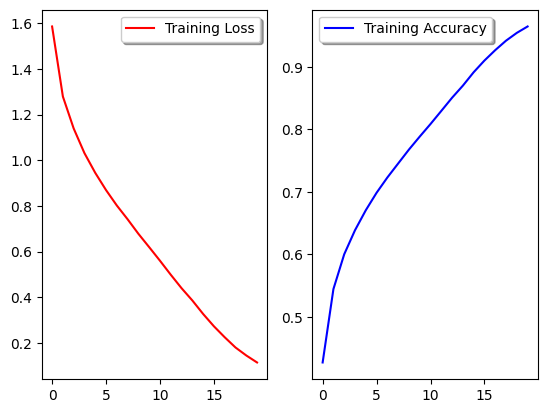

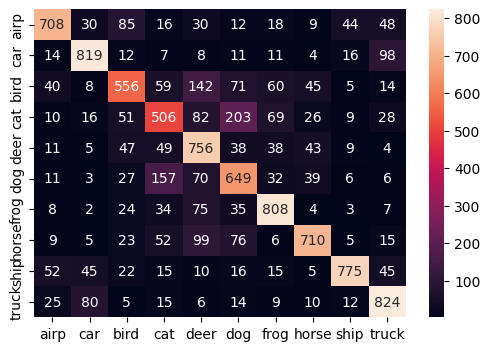

In [16]:
y_pred_onehot = model2.predict(x_test)

evaluate(history_Adam, y_pred_onehot, y_test_onehot, confusion_mat_en = 1)

#2. Network training with unbalanced data
First of all, we randomly remove 80% of the samples from the "car" and "airplane" classes.

In [45]:
del_dogs, remaind_dogs = train_test_split(ds['airp'], test_size=int(0.2 * len(x_train) / 10))
del_cats, remaind_cats = train_test_split(ds['car'], test_size=int(0.2 * len(x_train) / 10))

new_ds = ds.drop(['airp', 'car'], axis=1)
new_x_train = new_ds.to_numpy()

new_x_train = new_x_train.reshape((1,40000))[0]
indexs = np.concatenate([new_x_train, remaind_cats, remaind_dogs]) 


new_x_train = x_train[indexs]
remove_indexs = pd.concat([del_cats, del_dogs]).to_numpy()
# new_y_train = np.delete(y_train, remove_indexs)
new_y_train = y_train[indexs]
new_y_train_onehot = tf.one_hot(new_y_train.astype(np.int32), depth=10)

len(new_x_train)

42000

[[Text(0, 0, 'airp'),
  Text(1, 0, 'car'),
  Text(2, 0, 'bird'),
  Text(3, 0, 'cat'),
  Text(4, 0, 'deer'),
  Text(5, 0, 'dog'),
  Text(6, 0, 'frog'),
  Text(7, 0, 'horse'),
  Text(8, 0, 'ship'),
  Text(9, 0, 'truck')]]

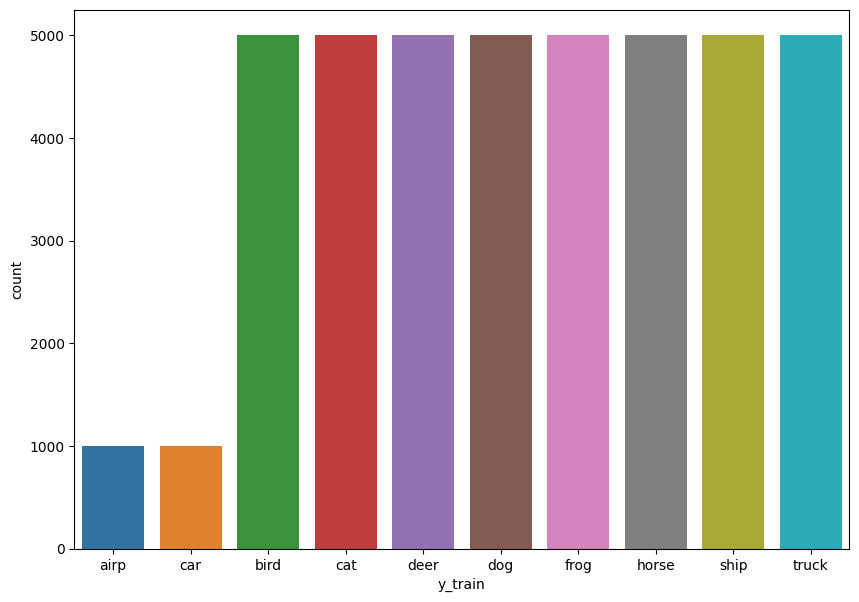

In [46]:
plt.figure(figsize=(10,7))
df = pd.DataFrame({'y_train':new_y_train})
p = sns.countplot(df, x = 'y_train')

p.set(xticklabels=classes)

Training the model with new reduced data

In [19]:
model3 = create_model(new_x_train)
model3.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['acc'])
history_reduced = model3.fit(new_x_train, new_y_train_onehot, batch_size=32, epochs=20, validation_data=(x_test, y_test_onehot))

Epoch 1/20
1313/1313 [==============================] - 11s 6ms/step - loss: 2.2108 - acc: 0.1169 - val_loss: 2.4366 - val_acc: 0.1055
Epoch 2/20
1313/1313 [==============================] - 8s 6ms/step - loss: 2.2070 - acc: 0.1213 - val_loss: 2.3901 - val_acc: 0.0970
Epoch 3/20
1313/1313 [==============================] - 7s 5ms/step - loss: 2.2055 - acc: 0.1249 - val_loss: 2.4441 - val_acc: 0.0998
Epoch 4/20
1313/1313 [==============================] - 8s 6ms/step - loss: 2.2042 - acc: 0.1279 - val_loss: 2.4636 - val_acc: 0.0929
Epoch 5/20
1313/1313 [==============================] - 7s 6ms/step - loss: 2.2018 - acc: 0.1323 - val_loss: 2.4505 - val_acc: 0.1188
Epoch 6/20
1313/1313 [==============================] - 7s 5ms/step - loss: 2.1963 - acc: 0.1432 - val_loss: 2.4496 - val_acc: 0.1083
Epoch 7/20
1313/1313 [==============================] - 8s 6ms/step - loss: 2.1875 - acc: 0.1545 - val_loss: 2.4903 - val_acc: 0.0883
Epoch 8/20
1313/1313 [==============================] - 8s 6m

Evaluation of `model3` with unbalanced train data shows reduced precision and recall

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

        airp       0.05      0.01      0.01      1000
         car       0.13      0.01      0.03      1000
        bird       0.10      0.14      0.12      1000
         cat       0.09      0.10      0.10      1000
        deer       0.10      0.15      0.12      1000
         dog       0.12      0.14      0.13      1000
        frog       0.11      0.15      0.13      1000
       horse       0.11      0.14      0.12      1000
        ship       0.10      0.08      0.09      1000
       truck       0.10      0.12      0.11      1000

    accuracy                           0.10     10000
   macro avg       0.10      0.10      0.09     10000
weighted avg       0.10      0.10      0.09     10000



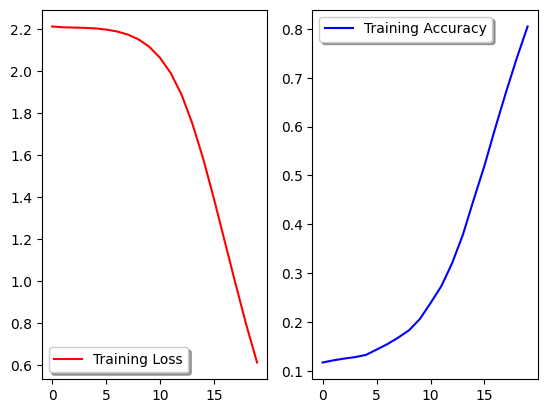

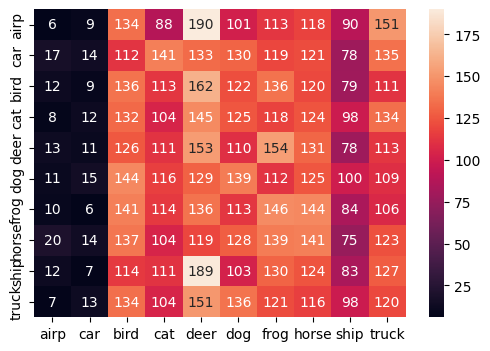

In [20]:
y_pred_onehot = model3.predict(x_test)

evaluate(history_reduced, y_pred_onehot, y_test_onehot, confusion_mat_en = 1)

When the distribution of classes in a dataset is skewed, with one or more classes having significantly fewer samples than others, as we can see it can lead to trained models that make biased predictions and show poor overall performance.Due to the absence of "automobile" and "airplane" classes in the training data, the neural network has not learned these classes as well as other classes, so it cannot recognize "automobile" and "airplane" in the test data.So, as you can see, **Recall and F1 are drastically reduced** under unbalanced conditions.

# 3. Data Augmentation
Impelement an augmentation frame

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(.5, .2),
])

Generate 4000 augmented images for each class `automobile` and `airplane`

In [48]:
augmented_images = []
augmented_labels = []
for i in range(len(new_x_train)):
  if(new_y_train[i] == 0 or new_y_train[i] == 1):
    image = new_x_train[i]
    for j in range(4):
      augmented_images.append(data_augmentation(image))
      augmented_labels.append(new_y_train[i])

Add new generated images to `x_train`

In [50]:
increased_x_train = np.concatenate([new_x_train, augmented_images]) 
increased_y_train = np.concatenate([new_y_train, augmented_labels]) 
increased_y_train_onehot = tf.one_hot(increased_y_train.astype(np.int32), depth=10)

print(len(new_x_train),len(augmented_images),len(increased_x_train))
print(len(new_y_train),len(augmented_labels),len(increased_y_train))

42000 8000 50000
42000 8000 50000


[[Text(0, 0, 'airp'),
  Text(1, 0, 'car'),
  Text(2, 0, 'bird'),
  Text(3, 0, 'cat'),
  Text(4, 0, 'deer'),
  Text(5, 0, 'dog'),
  Text(6, 0, 'frog'),
  Text(7, 0, 'horse'),
  Text(8, 0, 'ship'),
  Text(9, 0, 'truck')]]

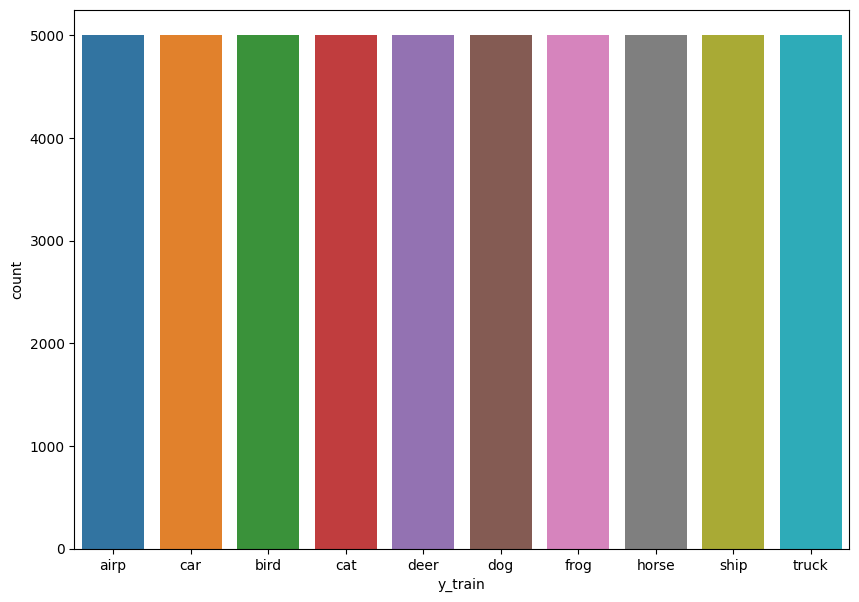

In [51]:
plt.figure(figsize=(10,7))
df = pd.DataFrame({'y_train':increased_y_train})
p = sns.countplot(df, x = 'y_train')

p.set(xticklabels=classes)

Now create a model with new augmentated train data

In [53]:
model4 = create_model(increased_x_train)
model4.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['acc'])
history_increased = model4.fit(increased_x_train, increased_y_train_onehot, batch_size=32, epochs=20, validation_data=(x_test, y_test_onehot))

Epoch 1/20
1563/1563 [==============================] - 11s 6ms/step - loss: 1.6364 - acc: 0.4224 - val_loss: 1.5341 - val_acc: 0.4493
Epoch 2/20
1563/1563 [==============================] - 9s 6ms/step - loss: 1.3054 - acc: 0.5455 - val_loss: 1.3357 - val_acc: 0.5297
Epoch 3/20
1563/1563 [==============================] - 9s 6ms/step - loss: 1.1335 - acc: 0.6059 - val_loss: 1.2030 - val_acc: 0.5727
Epoch 4/20
1563/1563 [==============================] - 8s 5ms/step - loss: 1.0192 - acc: 0.6469 - val_loss: 1.1406 - val_acc: 0.5974
Epoch 5/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.9343 - acc: 0.6775 - val_loss: 1.1234 - val_acc: 0.6057
Epoch 6/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.8614 - acc: 0.7020 - val_loss: 1.0226 - val_acc: 0.6469
Epoch 7/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7993 - acc: 0.7242 - val_loss: 0.9981 - val_acc: 0.6554
Epoch 8/20
1563/1563 [==============================] - 9s 6m

313/313 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

        airp       0.81      0.55      0.65      1000
         car       0.83      0.62      0.71      1000
        bird       0.58      0.66      0.62      1000
         cat       0.59      0.51      0.55      1000
        deer       0.63      0.74      0.68      1000
         dog       0.68      0.58      0.63      1000
        frog       0.76      0.82      0.79      1000
       horse       0.72      0.81      0.76      1000
        ship       0.76      0.84      0.80      1000
       truck       0.68      0.84      0.75      1000

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.69     10000
weighted avg       0.70      0.70      0.69     10000



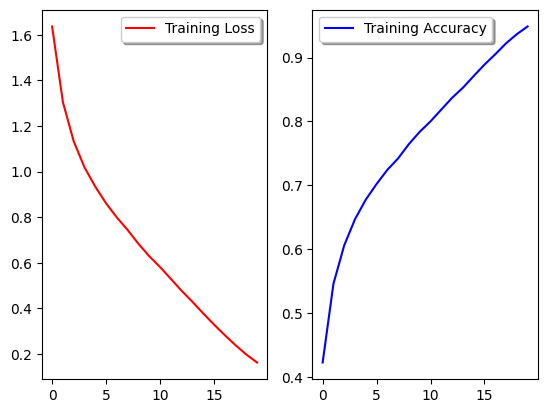

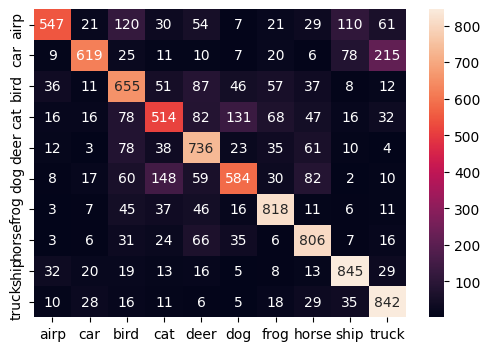

In [54]:
y_pred_onehot = model4.predict(x_test)

evaluate(history_increased, y_pred_onehot, y_test_onehot, confusion_mat_en = 1)

The percision and recall of model4 are much better than model3. Augmentation seems to be able to eliminate the bias introduced in model3.

# 4. The effect of regularization methods in the learning process
Add dropout and batch normalization layer to the model

In [55]:
model5 = create_model(x_train, dropout_en= 1, batch_norm_en= 1)
model5.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), metrics=['acc'])
history_increased = model5.fit(x_train, y_train_onehot, batch_size=32, epochs=40, validation_data=(x_test, y_test_onehot))

Epoch 1/40
1563/1563 [==============================] - 16s 8ms/step - loss: 2.0520 - acc: 0.2654 - val_loss: 1.7023 - val_acc: 0.4211
Epoch 2/40
1563/1563 [==============================] - 15s 10ms/step - loss: 1.7927 - acc: 0.3599 - val_loss: 1.5630 - val_acc: 0.4676
Epoch 3/40
1563/1563 [==============================] - 15s 9ms/step - loss: 1.6865 - acc: 0.4008 - val_loss: 1.4524 - val_acc: 0.5093
Epoch 4/40
1563/1563 [==============================] - 15s 10ms/step - loss: 1.6154 - acc: 0.4278 - val_loss: 1.3875 - val_acc: 0.5328
Epoch 5/40
1563/1563 [==============================] - 18s 11ms/step - loss: 1.5646 - acc: 0.4451 - val_loss: 1.3357 - val_acc: 0.5448
Epoch 6/40
1563/1563 [==============================] - 14s 9ms/step - loss: 1.5167 - acc: 0.4636 - val_loss: 1.2950 - val_acc: 0.5620
Epoch 7/40
1563/1563 [==============================] - 12s 8ms/step - loss: 1.4830 - acc: 0.4726 - val_loss: 1.2683 - val_acc: 0.5727
Epoch 8/40
1563/1563 [==============================

In [57]:
model5 = create_model(x_train, dropout_en= 1, batch_norm_en= 1)
model5.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), metrics=['acc'])
history_increased = model5.fit(x_train, y_train_onehot, batch_size=32, epochs=50, validation_data=(x_test, y_test_onehot))

Epoch 1/50
1563/1563 [==============================] - 15s 8ms/step - loss: 2.0461 - acc: 0.2646 - val_loss: 1.6809 - val_acc: 0.4226
Epoch 2/50
1563/1563 [==============================] - 12s 7ms/step - loss: 1.7740 - acc: 0.3664 - val_loss: 1.5304 - val_acc: 0.4755
Epoch 3/50
1563/1563 [==============================] - 11s 7ms/step - loss: 1.6720 - acc: 0.4010 - val_loss: 1.4366 - val_acc: 0.5081
Epoch 4/50
1563/1563 [==============================] - 12s 8ms/step - loss: 1.6068 - acc: 0.4267 - val_loss: 1.3800 - val_acc: 0.5301
Epoch 5/50
1563/1563 [==============================] - 12s 8ms/step - loss: 1.5537 - acc: 0.4448 - val_loss: 1.3273 - val_acc: 0.5499
Epoch 6/50
1563/1563 [==============================] - 13s 8ms/step - loss: 1.5126 - acc: 0.4624 - val_loss: 1.2825 - val_acc: 0.5622
Epoch 7/50
1563/1563 [==============================] - 12s 8ms/step - loss: 1.4662 - acc: 0.4773 - val_loss: 1.2464 - val_acc: 0.5775
Epoch 8/50
1563/1563 [==============================] -

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

        airp       0.69      0.84      0.76      1000
         car       0.81      0.85      0.83      1000
        bird       0.59      0.62      0.61      1000
         cat       0.58      0.52      0.55      1000
        deer       0.70      0.59      0.64      1000
         dog       0.66      0.55      0.60      1000
        frog       0.65      0.88      0.75      1000
       horse       0.78      0.74      0.76      1000
        ship       0.84      0.81      0.83      1000
       truck       0.85      0.75      0.80      1000

    accuracy                           0.71     10000
   macro avg       0.72      0.71      0.71     10000
weighted avg       0.72      0.71      0.71     10000



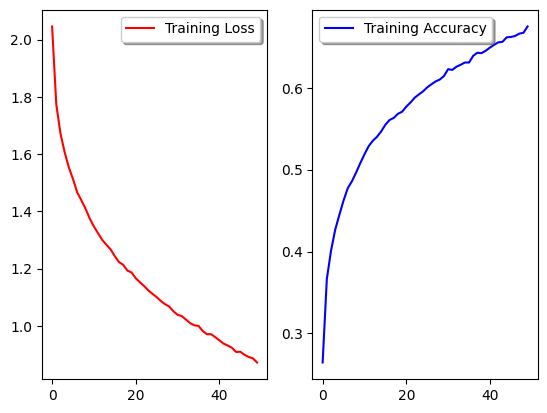

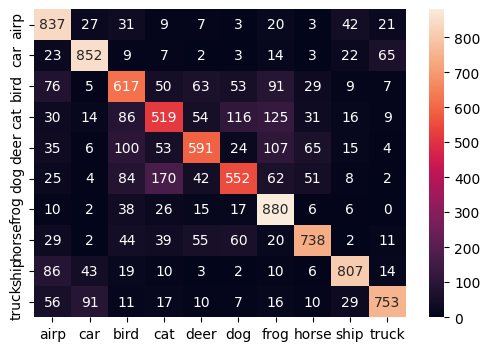

In [58]:
y_pred_onehot = model5.predict(x_test)

evaluate(history_increased, y_pred_onehot, y_test_onehot, confusion_mat_en = 1)

`Dropout` probabilistically remove inputs during training and `Batch normalizing` can normal its input that accelerate Deep Network Training by Reducing Internal Covariate Shift.
Both of them avoid overfitting in deep learning neural networks.

# Conclusion
There are many factors that have effect in CNN performance, like optimizers, destribution of train and test data, order of layers, learning rate,... and we can use some regulation methods to avoid overfitting the model

# Resources
* https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
* https://www.kaggle.com/code/amyjang/tensorflow-cifar10-cnn-tutorial
* https://github.com/Sara-Rezaeimanesh/FNN-with-Tensorflow
* https://neptune.ai/blog/data-augmentation-in-python
* https://machinelearningmastery.com/introduction-to-regularization-to-reduce-overfitting-and-improve-generalization-error/
